In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import iglob
from scipy import stats

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_palette("pastel")
mpl.rcParams['figure.figsize'] = (20, 20)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Computer Modern"
plt.rcParams["font.size"] = "24"

In [3]:
def load_final(experiment, verbose=False):
    pth = '../experiments/*/{}/*/*_test_final.pkl'.format(experiment)
    print("looking for {}".format(pth))
    pkls = [p for p in iglob(pth)]
    print("loading {} pkls".format(len(pkls)))
    dfs = []
    for p in pkls:
        if verbose:
            print(p)
        expid = p.split('/')[-2].split('_')[3]
        if verbose:
            print(expid)
        expid = int(expid)
        _df = pd.read_pickle(p)
        _df['experiment_id'] = expid
        dfs.append(_df)
    df = pd.concat(dfs, ignore_index=True)
    # ignore 0.000 threshold
    df = df[~df['threshold'].isin([0.0])]
    return df

## Define Metrics

In [4]:
METRICS = ['accuracy', 'f1', 'precision', 'recall']
LOSSES = ['accuracy_05', 'f1_05', 'roc', 'bce']

In [5]:
def flatten(df):
    DATASETS = df.dataset.unique()
    cols = ['dataset', 'loss', 'metric', 'value', 'threshold']
    THRESHOLDS = [0.5]
    df_dict = {}
    for col in cols:
        df_dict[col] = []
    for ds in DATASETS:
        for loss in LOSSES:
            # array of metric values across trials
            for metric in METRICS:
                for i, row in df[(df['dataset']==ds)&(df['loss']==loss)].iterrows():
                    df_dict['loss'].append(loss)
                    df_dict['dataset'].append(ds)
                    df_dict['metric'].append(metric)
                    df_dict['threshold'].append(row.threshold)
                    df_dict['value'].append(row[metric])
    return pd.DataFrame.from_dict(df_dict)

## Define Trials

In [29]:
trials = {
    # 4096
    'xlarge': 't76',
    # 2048
    'large': 't72',
    # 1024
    'medium': 't73',
    # 128
    'small': 't74',
    # 64
    #'xsmall': 't75',
}
sizes = {
    # 4096
    'xlarge': 4096,
    # 2048
    'large': 2048,
    # 1024
    'medium': 1024,
    # 128
    'small': 128,
    # 64
    #'xsmall': 't75',
}

In [25]:
# load em up
dfs = {}
for size, trial in trials.items():
    dfs[size] = flatten(load_final(trial))

looking for ../experiments/*/t76/*/*_test_final.pkl
loading 70 pkls
looking for ../experiments/*/t72/*/*_test_final.pkl
loading 70 pkls
looking for ../experiments/*/t73/*/*_test_final.pkl
loading 70 pkls
looking for ../experiments/*/t74/*/*_test_final.pkl
loading 70 pkls


## Tabular Score Results

In [7]:
tables = {}
for size, _df in dfs.items():
    print("SIZE: ", size)
    DATASETS = _df.dataset.unique()
    LOSSES = _df.loss.unique()
    # one table per dataset
    for ds in DATASETS:
        print(ds)
        rows = [','.join(METRICS)]
        for loss in LOSSES:
            #print("LOSS:", loss)
            row = [loss]
            for metric in METRICS:
                v = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)].value
                #print("METRIC ({}): {:.03f}".format(metric, v.mean()))
                row.append("${:.03f} \pm {:.03f}$".format(v.mean(), v.std()))
            rows.append(','.join(row))
        print("--- copy {} ---".format(ds))
        tables[size] = "\n".join(rows)
        print(tables[size])

SIZE:  xlarge
mammography
--- copy mammography ---
accuracy,f1,precision,recall
accuracy_05,$0.976 \pm 0.003$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
f1_05,$0.985 \pm 0.002$,$0.688 \pm 0.040$,$0.735 \pm 0.060$,$0.654 \pm 0.065$
roc,$0.496 \pm 0.459$,$0.135 \pm 0.176$,$0.234 \pm 0.349$,$0.678 \pm 0.415$
bce,$0.977 \pm 0.022$,$0.423 \pm 0.231$,$0.670 \pm 0.310$,$0.408 \pm 0.271$
SIZE:  large
mammography
--- copy mammography ---
accuracy,f1,precision,recall
accuracy_05,$0.977 \pm 0.002$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
f1_05,$0.986 \pm 0.003$,$0.690 \pm 0.039$,$0.722 \pm 0.074$,$0.672 \pm 0.076$
roc,$0.542 \pm 0.448$,$0.163 \pm 0.203$,$0.264 \pm 0.368$,$0.677 \pm 0.411$
bce,$0.979 \pm 0.021$,$0.477 \pm 0.207$,$0.739 \pm 0.260$,$0.455 \pm 0.259$
SIZE:  medium
mammography
--- copy mammography ---
accuracy,f1,precision,recall
accuracy_05,$0.976 \pm 0.001$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
f1_05,$0.988 \pm 0.002$,$0.723 \pm 0.063$,$0.780 

## Score Plots

In [8]:
_dfs = [] 
for size, _df in dfs.items():
    _df['size'] = size
    _dfs.append(_df)
_df = pd.concat(_dfs, ignore_index = True)
_df

,dataset,loss,metric,value,threshold,size
0,mammography,accuracy_05,accuracy,0.973178,0.001,xlarge
1,mammography,accuracy_05,accuracy,0.973178,0.002,xlarge
2,mammography,accuracy_05,accuracy,0.973178,0.003,xlarge
3,mammography,accuracy_05,accuracy,0.973178,0.004,xlarge
4,mammography,accuracy_05,accuracy,0.973178,0.005,xlarge
...,...,...,...,...,...,...
639355,mammography,bce,recall,0.107143,0.995,small
639356,mammography,bce,recall,0.107143,0.996,small
639357,mammography,bce,recall,0.107143,0.997,small
639358,mammography,bce,recall,0.107143,0.998,small


Index(['dataset', 'loss', 'metric', 'value', 'threshold', 'size'], dtype='object')
loss: accuracy_05, metric: accuracy, samples: 9990, mean: 0.9762181493071078, std: 0.00251939347551988
loss: accuracy_05, metric: accuracy, samples: 9990, mean: 0.977335717478766, std: 0.0018329035407296823
loss: accuracy_05, metric: accuracy, samples: 9990, mean: 0.9758158247653108, std: 0.001271539963494619
loss: accuracy_05, metric: accuracy, samples: 9990, mean: 0.9760393383996425, std: 0.0014444616062062787
Index(['dataset', 'loss', 'metric', 'value', 'threshold', 'size'], dtype='object')
loss: accuracy_05, metric: f1, samples: 9990, mean: 0.0, std: 0.0
loss: accuracy_05, metric: f1, samples: 9990, mean: 0.0, std: 0.0
loss: accuracy_05, metric: f1, samples: 9990, mean: 0.0, std: 0.0
loss: accuracy_05, metric: f1, samples: 9990, mean: 0.0, std: 0.0
Index(['dataset', 'loss', 'metric', 'value', 'threshold', 'size'], dtype='object')
loss: accuracy_05, metric: precision, samples: 9990, mean: 0.0, std: 0.

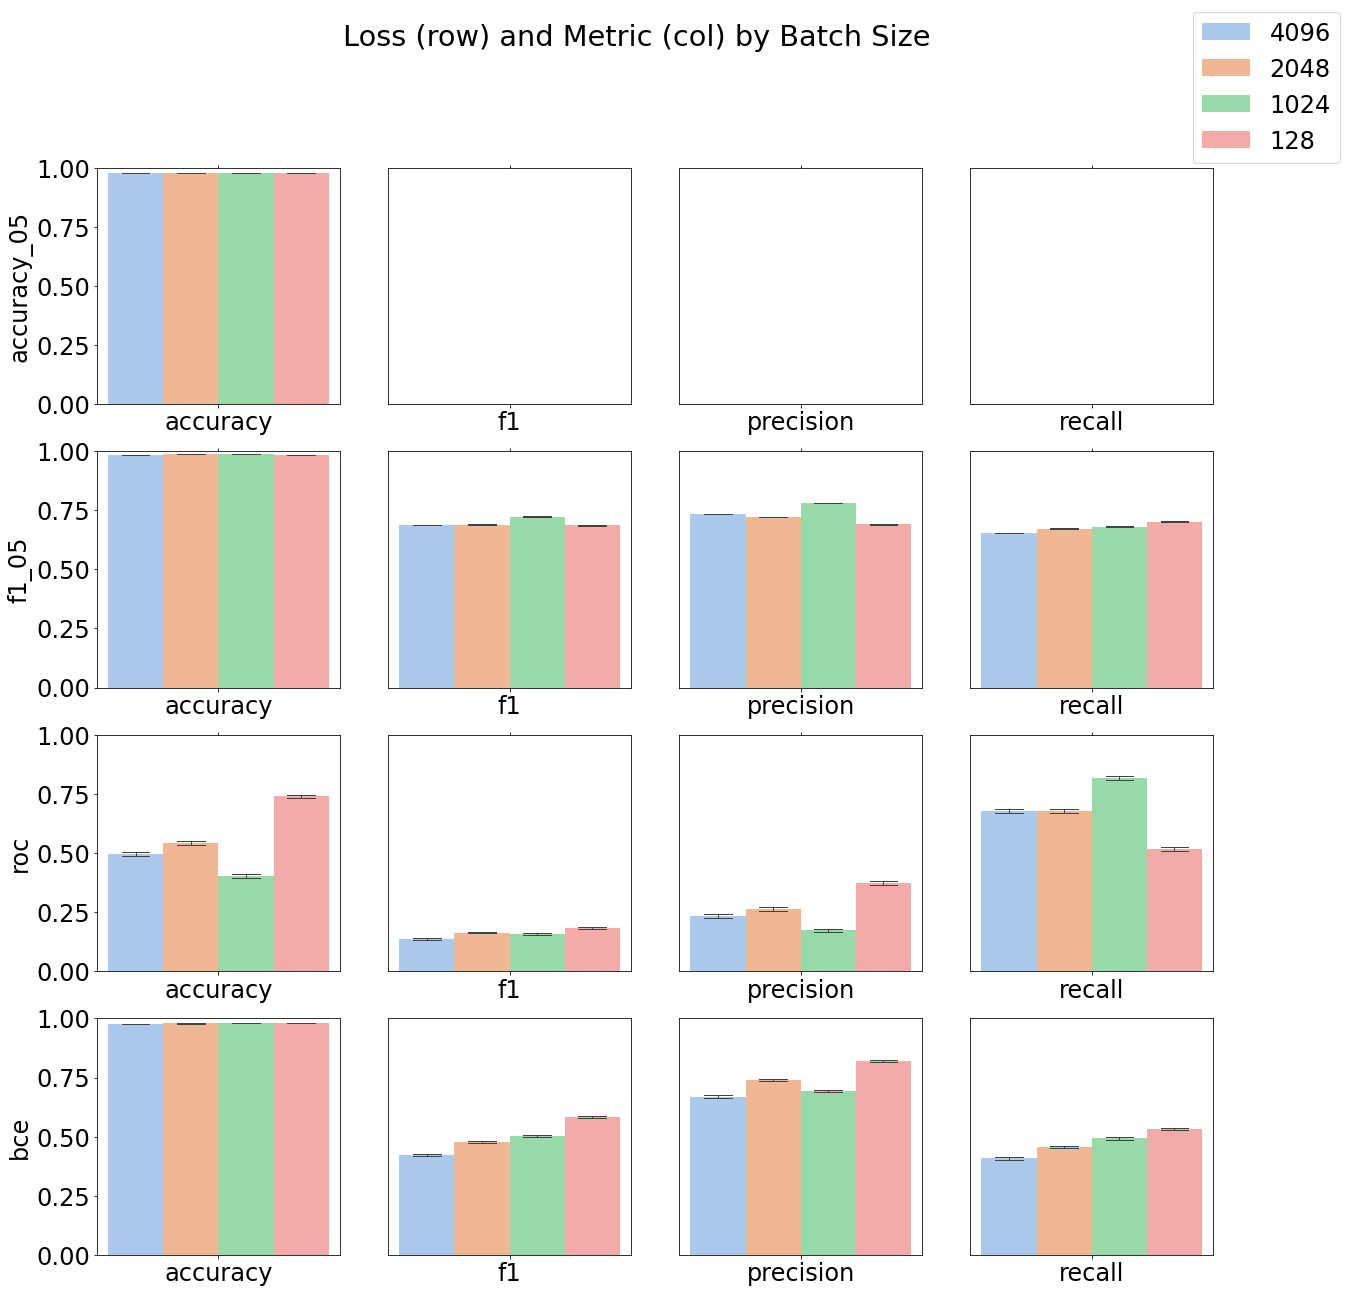

In [46]:
# rows, cols
fig, axs = plt.subplots(len(LOSSES), len(METRICS))
#fig.suptitle(name)
for i, loss in enumerate(LOSSES):
    for j, metric in enumerate(METRICS):
        _adf = _df[(_df['metric']==metric)&(_df['loss']==loss)]
        print(_adf.columns)
        for size in _adf['size'].unique():
            _adf_sized = _adf[_adf['size']==size]
            print("loss: {}, metric: {}, samples: {}, mean: {}, std: {}".format(loss, metric, _adf_sized['value'].count(), _adf_sized['value'].mean(), _adf_sized['value'].std()))
        #axs[i][j].set_title(loss)
        sns.barplot(x="metric", y="value", data=_adf, hue="size", capsize=.1, errwidth=1.0, ax=axs[i][j])
        axs[i][j].set(ylim=(0, 1))
        axs[i][j].set(xlabel="", ylabel=loss)
        axs[i][j].get_legend().remove()
        if j != 0:
            axs[i][j].set_yticks([])
            axs[i][j].set_ylabel("")
        if i != len(METRICS) - 1:
            axs[i][j].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        else:
            axs[i][j].set_xlabel("")

handles, labels = axs[i][j].get_legend_handles_labels()
print(labels)
print(sizes)
labels = [sizes[label] for label in labels]
print(labels)
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Loss (row) and Metric (col) by Batch Size")
plt.show()

- 2048 is a good balance between f1 loss and bce loss

## Batch Score Comparisons



 xlarge
../experiments/complete/t76/*/*.csv
   Unnamed: 0 loss  epoch  batch  train_f1    all_f1  delta_f1
0           0  bce      0      0  0.043935  0.045443  0.001508
1           1  bce      0      1  0.044104  0.045272  0.001168
2           2  bce      1      0  0.043468  0.045101  0.001633
3           3  bce      1      1  0.044104  0.044759  0.000656
4           4  bce      2      0  0.041597  0.044246  0.002649
        Unnamed: 0 loss  epoch  batch  train_f1    all_f1  delta_f1
115687        2449  roc   1224      1       0.0  0.007663  0.007663
115688        2450  roc   1225      0       0.0  0.007663  0.007663
115689        2451  roc   1225      1       0.0  0.007663  0.007663
115690        2452  roc   1226      0       0.0  0.007663  0.007663
115691        2453  roc   1226      1       0.0  0.007663  0.007663
train_f1 mean:  0.39650488290230634 , std:  0.28591074733442917
all_f1 mean:  0.3901509170331652 , std:  0.2789823090197648
delta_f1 mean:  -0.006353965869141225 , std:

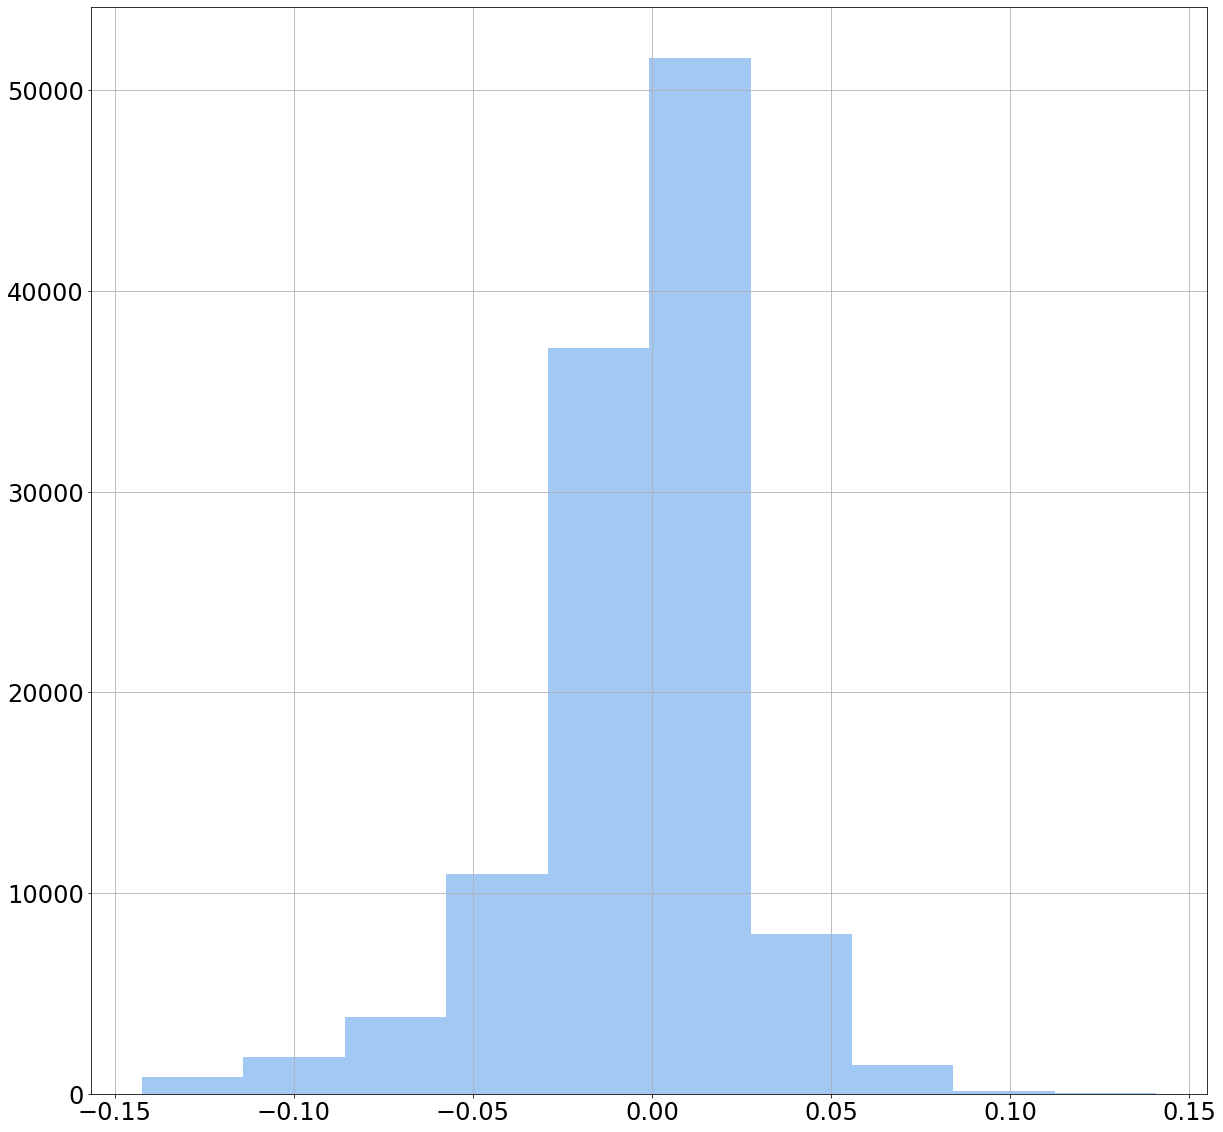

Ttest_indResult(statistic=5.410191530841657, pvalue=6.301964927328875e-08)
Ttest_relResult(statistic=74.71415819450698, pvalue=0.0)


 large
../experiments/complete/t72/*/*.csv
   Unnamed: 0    loss  epoch  batch  train_f1    all_f1  delta_f1
0           0  f1_max      0      0  0.117647  0.071685 -0.045962
1           1  f1_max      0      1  0.076923  0.092199  0.015276
2           2  f1_max      0      2  0.098361  0.092199 -0.006162
3           3  f1_max      0      3  0.222222  0.091873 -0.130349
4           4  f1_max      1      0  0.150943  0.098592 -0.052352
        Unnamed: 0 loss  epoch  batch  train_f1    all_f1  delta_f1
178947        1855  bce    463      3  0.545455  0.591133  0.045678
178948        1856  bce    464      0  0.560976  0.591133  0.030157
178949        1857  bce    464      1  0.645161  0.591133 -0.054028
178950        1858  bce    464      2  0.657534  0.592593 -0.064942
178951        1859  bce    464      3  0.545455  0.596059  0.050605
train_f1 mean:  0.4

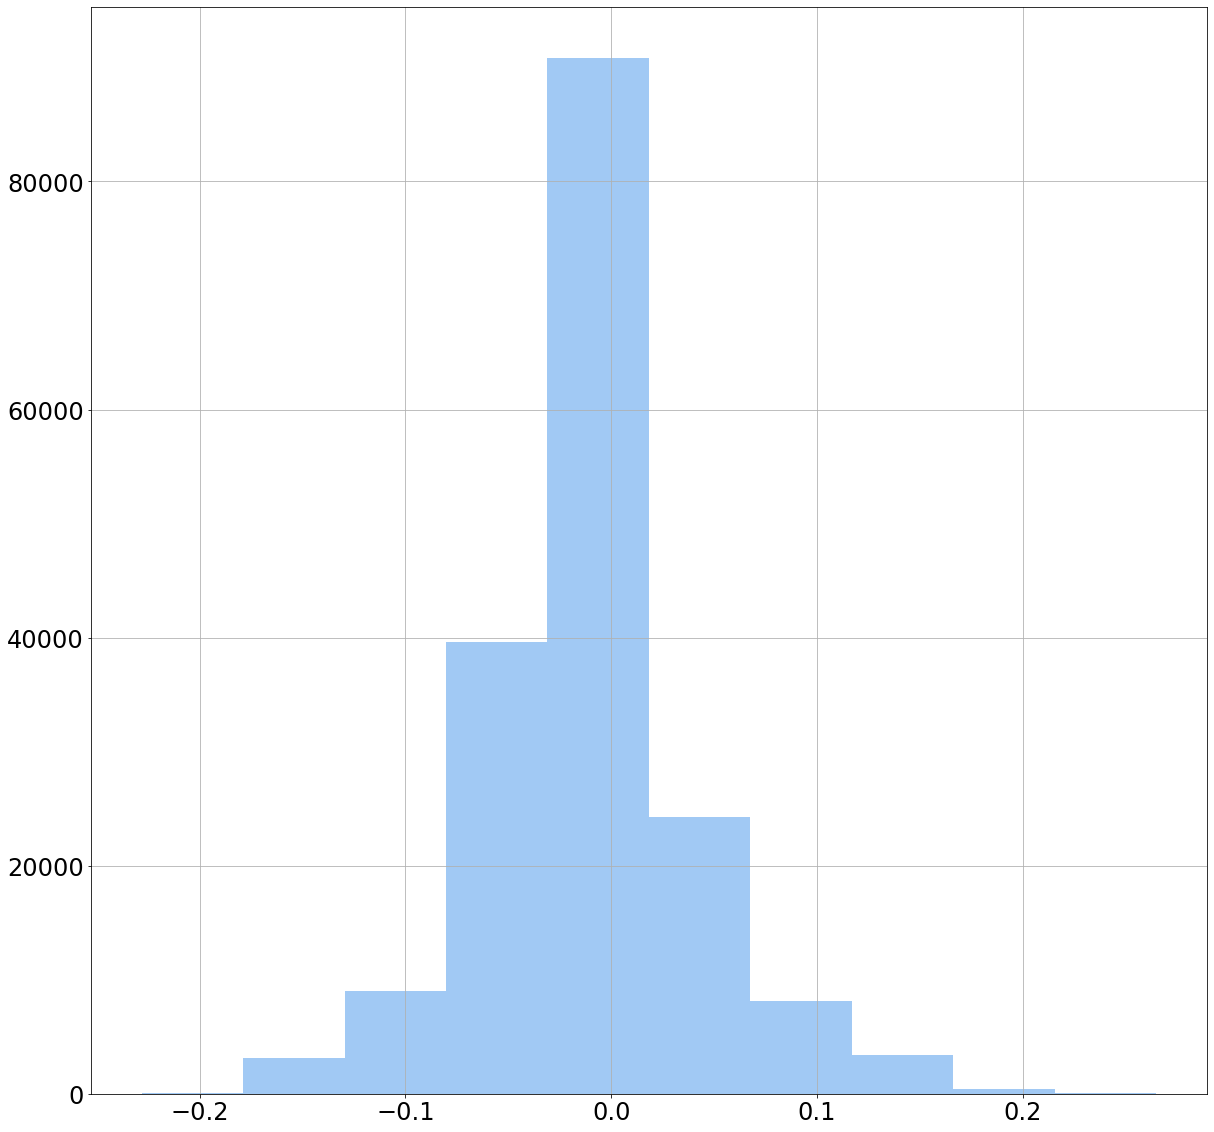

Ttest_indResult(statistic=9.309744913046275, pvalue=1.2883044936886521e-20)
Ttest_relResult(statistic=71.67138394035689, pvalue=0.0)


 medium
../experiments/complete/t73/*/*.csv
   Unnamed: 0 loss  epoch  batch  train_f1  all_f1  delta_f1
0           0  bce      0      0       0.0     0.0       0.0
1           1  bce      0      1       0.0     0.0       0.0
2           2  bce      0      2       0.0     0.0       0.0
3           3  bce      0      3       0.0     0.0       0.0
4           4  bce      0      4       0.0     0.0       0.0
        Unnamed: 0    loss  epoch  batch  train_f1    all_f1  delta_f1
254375        4027  f1_max    575      2  0.736842  0.708000 -0.028842
254376        4028  f1_max    575      3  0.792453  0.708000 -0.084453
254377        4029  f1_max    575      4  0.820513  0.713710 -0.106803
254378        4030  f1_max    575      5  0.723404  0.712551 -0.010854
254379        4031  f1_max    575      6  0.634146  0.709939  0.075793
train_f1 mean:  0.42411695700

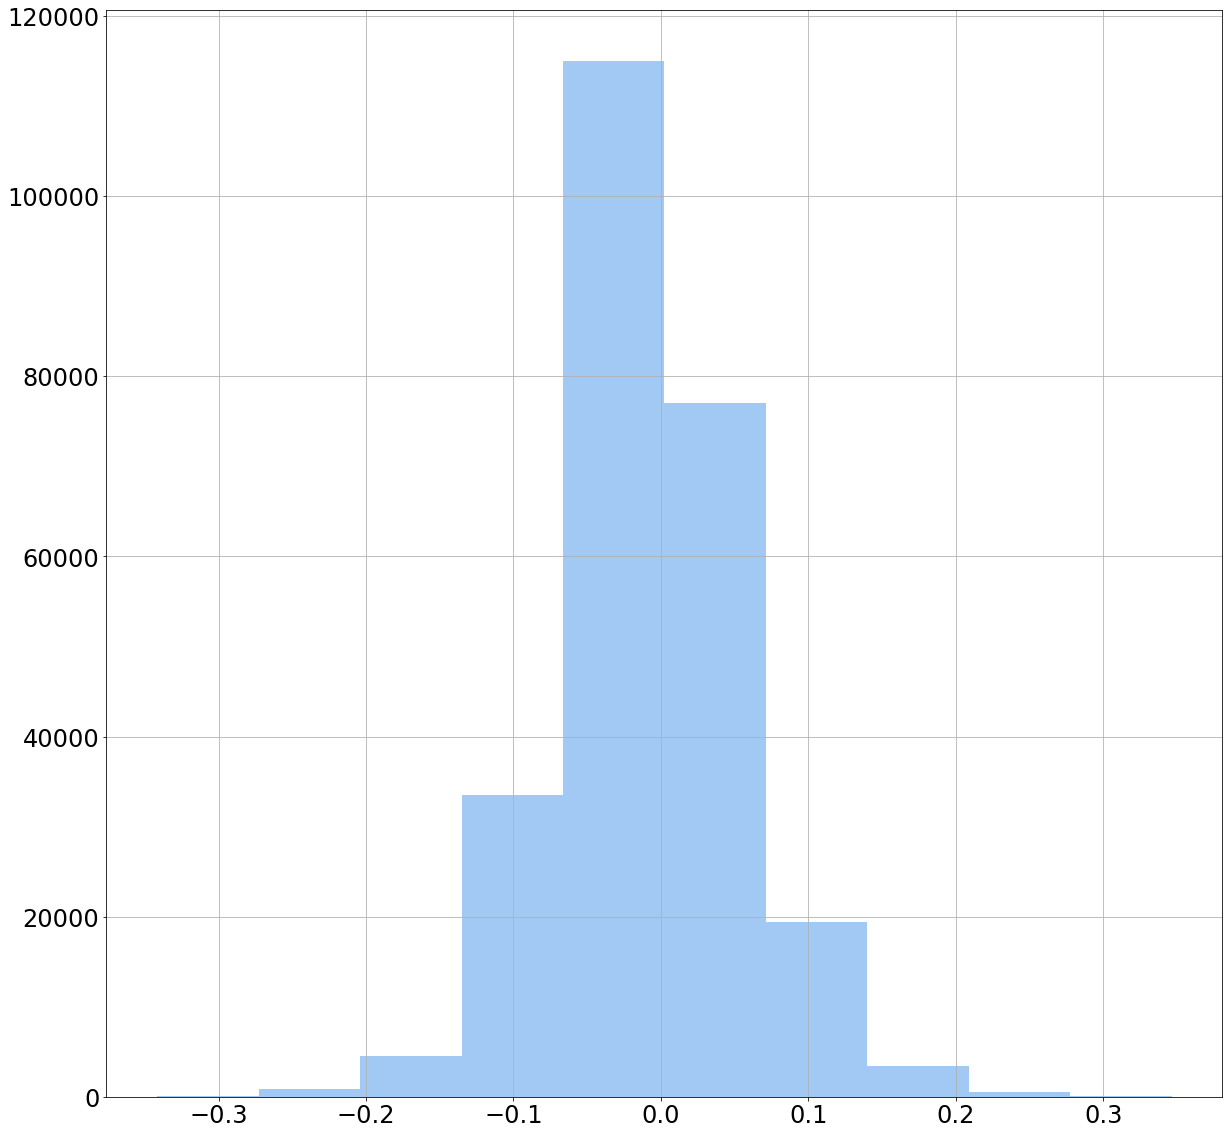

Ttest_indResult(statistic=7.128336126773281, pvalue=1.017236610204535e-12)
Ttest_relResult(statistic=47.63276639789056, pvalue=0.0)


 small
../experiments/complete/t74/*/*.csv
   Unnamed: 0   loss  epoch  batch  train_f1  all_f1  delta_f1
0           0  f2_05      0      0       0.0     0.0       0.0
1           1  f2_05      0      1       0.0     0.0       0.0
2           2  f2_05      0      2       0.0     0.0       0.0
3           3  f2_05      0      3       0.0     0.0       0.0
4           4  f2_05      0      4       0.0     0.0       0.0
        Unnamed: 0   loss  epoch  batch  train_f1    all_f1  delta_f1
797995        5875  f3_05    104     51  0.000000  0.530559  0.530559
797996        5876  f3_05    104     52  0.857143  0.531088 -0.326055
797997        5877  f3_05    104     53  0.250000  0.529032  0.279032
797998        5878  f3_05    104     54  0.500000  0.526992  0.026992
797999        5879  f3_05    104     55  0.400000  0.526316  0.126316
train_f1 mean:  0.2943432

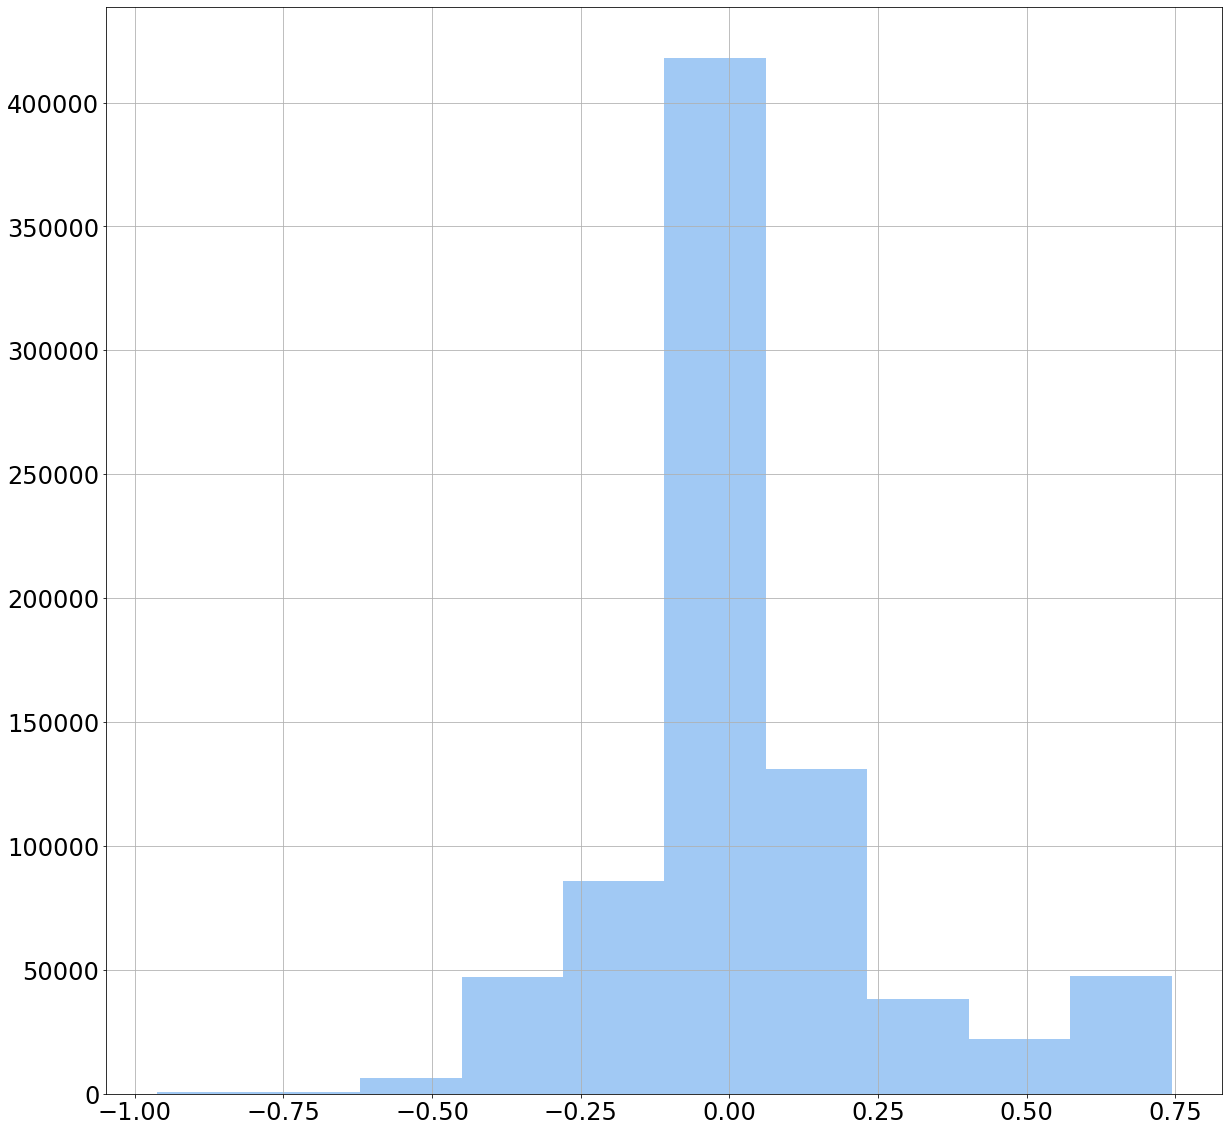

Ttest_indResult(statistic=-82.49778464821065, pvalue=0.0)
Ttest_relResult(statistic=-159.1402352634357, pvalue=0.0)


In [52]:
for size, trial in trials.items():
    print(f"\n\n {size}")
    globpath = f"../experiments/complete/{trial}/*/*.csv"
    print(globpath)
    # print(len([p for p in iglob(globpath)]))
    df = pd.concat([pd.read_csv(f) for f in iglob(globpath)], ignore_index = True)
    print(df.head())
    print(df.tail())
    print("train_f1 mean: ", df['train_f1'].mean(), ", std: ", df['train_f1'].std())
    print("all_f1 mean: ", df['all_f1'].mean(), ", std: ", df['all_f1'].std())
    print("delta_f1 mean: ", df['delta_f1'].mean(), ", std: ", df['delta_f1'].std())
    
    df['delta_f1'].hist()
    plt.show()
    
    # t-test
    # independent
    print(stats.ttest_ind(df['train_f1'],df['all_f1'],equal_var = False))
    # related
    print(stats.ttest_rel(df['train_f1'],df['all_f1']))

In [51]:
%ls ../experiments/complete/

t0/   t12/  t21/  t26/  t3/   t34/  t4/   t47/  t50/  t55/  t73/
t1/   t13/  t22/  t27/  t30/  t35/  t42/  t48/  t51/  t6/   t76/
t10/  t14/  t23/  t28/  t32/  t36/  t44/  t49/  t52/  t7/   t8/
t11/  t2/   t24/  t29/  t33/  t38/  t45/  t5/   t53/  t72/  t9/


average absolute error and variance for absolute

- in general the error is small, but increases as the batch size decreases. need to have enough samples to compute the f1 score

maybe add plots to the supp. material

a more detailed analysis of the results is provided in the supp. material